In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import importlib

for module in ['kooplearn', 'datasets', 'matplotlib', 'ml-confs']: # !! Add here any additional module that you need to install on top of kooplearn
    try:
        importlib.import_module(module)
    except ImportError:
        if module == 'kooplearn':
            module = 'kooplearn[full]'
        %pip install -q {module}

import data_pipeline
import ml_confs
from datasets import load_from_disk
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import lightning
from typing import Optional, NamedTuple
import logging
from kooplearn.abc import TrainableFeatureMap
from kooplearn.models import Linear, Nonlinear, Kernel
from kooplearn.models.feature_maps.nn import NNFeatureMap
from kooplearn.nn.data import collate_context_dataset
from kooplearn.nn import DPLoss, VAMPLoss
from kooplearn.data import traj_to_contexts
from sklearn.gaussian_process.kernels import RBF

python(41797) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Note: you may need to restart the kernel to use updated packages.


Data directory not found, preprocessing data.


Found cached dataset mnist (/Users/erfanmirzaei/.cache/huggingface/datasets/mnist/mnist/1.0.0/9d494b7f466d6931c64fb39d58bb1249a4d85c9eb9865d9bc20960b999e2a332)


  0%|          | 0/2 [00:00<?, ?it/s]

Filter (num_proc=8):   0%|          | 0/60000 [00:00<?, ? examples/s]

Filter (num_proc=8):   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter (num_proc=8):   0%|          | 0/60000 [00:00<?, ? examples/s]

Filter (num_proc=8):   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter (num_proc=8):   0%|          | 0/60000 [00:00<?, ? examples/s]

Filter (num_proc=8):   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter (num_proc=8):   0%|          | 0/60000 [00:00<?, ? examples/s]

Filter (num_proc=8):   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter (num_proc=8):   0%|          | 0/60000 [00:00<?, ? examples/s]

Filter (num_proc=8):   0%|          | 0/10000 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/8000 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/1001 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/2001 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/8000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1001 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2001 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/8000 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/1001 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/2001 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/8000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1001 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2001 [00:00<?, ? examples/s]

train (8000) example: tensor([0, 1, 2, 3, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1])
test (1001) example: tensor([2, 3, 2, 3, 4, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2])
validation (2001) example: tensor([3, 3, 4, 0, 1, 2, 3, 0, 1, 2, 3, 4, 0, 1, 2, 0])


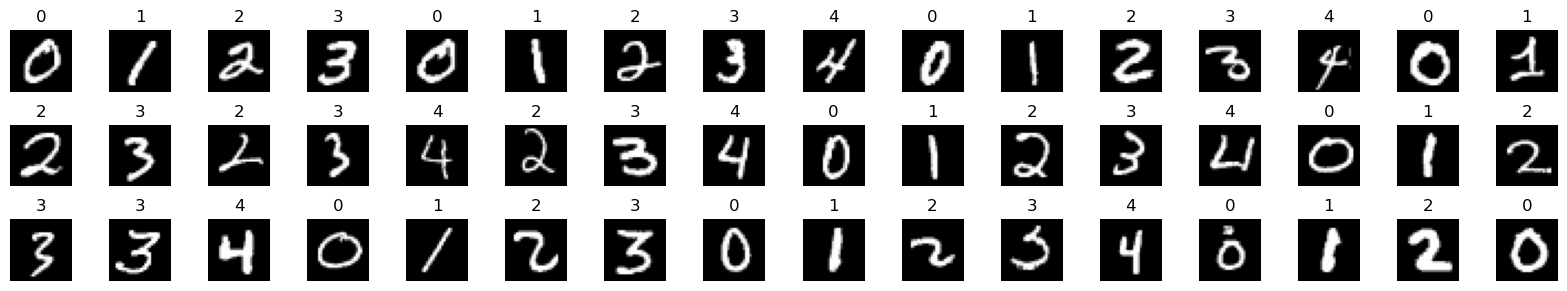

In [3]:
data_pipeline.main() # Run data download and preprocessing
configs = ml_confs.from_file('configs.yaml') # Load configs
ordered_MNIST = load_from_disk('__data__') # Load dataset (torch)
Noisy_ordered_MNIST = load_from_disk('__data__Noisy') # Load dataset (torch)

device = 'gpu' if torch.cuda.is_available() else 'cpu'

fig, ax = plt.subplots(3, 16, figsize=(16, 3))
for j, split in enumerate(['train', 'test', 'validation']):
    print(f'{split} ({len(Noisy_ordered_MNIST[split])}) example: {Noisy_ordered_MNIST[split]["label"][:16]}')
    for i in range(16):
        data = Noisy_ordered_MNIST[split][i]
        ax[j, i].imshow(data['image'], cmap='gray')
        ax[j, i].set_title(data['label'].item())
        ax[j, i].axis('off')
fig.tight_layout()

## Setting up a validation scheme
The validation of each model will be performed as follows: starting from a test image of the digit $c$, we will predict the next image by calling `model.predict`. The prediction should be an MNIST-alike image of the digit $c+1$ (modulo `configs.classes`). We will feed this prediction to a very strong MNIST classifier, and evaluate how its accuracy degrades over time.

### Defining the _oracle_ classifier

In [3]:
import torch.nn as nn
import torch

#Setting up the architecture
class CNNEncoder(nn.Module):
    def __init__(self, num_classes):
        super(CNNEncoder, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # Fully connected layer, output num_classes classes
        self.out = nn.Sequential(
            nn.Linear(32 * 7 * 7, num_classes)
        )  
        torch.nn.init.orthogonal_(self.out[0].weight)      
    
    def forward(self, X):
        if X.dim() == 3:
            X = X.unsqueeze(1) # Add a channel dimension if needed
        X = self.conv1(X)
        X = self.conv2(X)
        # Flatten the output of conv2
        X = X.view(X.size(0), -1)       
        output = self.out(X)
        return output

We wrap the oracle classifier around a `kooplearn.abc.TrainableFeatureMap`. This will allow us to easily replicate the setting of Kostic et al. 2022, and it is pedagogical to show how `kooplearn` can be extended.

In [4]:
from kooplearn.abc import TrainableFeatureMap

import os
from typing import Optional, NamedTuple
import logging

import lightning
import numpy as np

class Metrics(NamedTuple):
    train_acc: list[float]
    train_steps: list[float]
    val_acc: list[float]
    val_steps: list[float]


#Following kooplearn implementations, we define a Pytorch Lightning module and then wrap it in a TrainableFeatureMap
class ClassifierModule(lightning.LightningModule):
    def __init__(self, num_classes: int, learning_rate: float):
        super().__init__()
        self.num_classes = num_classes
        self.encoder = CNNEncoder(num_classes=num_classes)
        self.learning_rate = learning_rate
        self.loss_fn = torch.nn.CrossEntropyLoss()
    
    def on_fit_start(self):
        self.metrics = Metrics([], [], [], [])

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr = self.learning_rate)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        images, labels = batch['image'], batch['label']
        output = self.encoder(images)               
        loss = self.loss_fn(output, labels)
        with torch.no_grad():
            pred_labels = output.argmax(dim=1)
            accuracy = (pred_labels == labels).float().mean()
        
        #Log metrics
        self.metrics.train_acc.append(accuracy.item())
        self.metrics.train_steps.append(self.global_step)
        
        return {'loss': loss, 'train/accuracy': accuracy}
    
    def validation_step(self, batch, batch_idx):
        images, labels = batch['image'], batch['label']
        output = self.encoder(images)  
        pred_labels = output.argmax(dim=1)
        accuracy = (pred_labels == labels).float().mean() # Scalar

        self.metrics.val_acc.append(accuracy.item())
        self.metrics.val_steps.append(self.global_step)

        return {'val/accuracy': accuracy}
    
class ClassifierFeatureMap(TrainableFeatureMap):
    def __init__(
                self, 
                num_classes: int,
                learning_rate: float,
                trainer: lightning.Trainer,
                seed: Optional[int] = None  
                ):
        #Set rng seed
        lightning.seed_everything(seed)
        self.seed = seed
        self.lightning_module = ClassifierModule(num_classes, learning_rate)
        
        #Init trainer
        self.lightning_trainer = trainer
        self._is_fitted = False
        
    @property
    def is_fitted(self) -> bool:
        return self._is_fitted
    
    @property
    def lookback_len(self) -> int:
        return 1 #Hardcoding it here, as we are not using lookback windows
    
    #Not tested
    def save(self, path: os.PathLike):
        raise NotImplementedError
    
    #Not tested
    @classmethod
    def load(cls, path: os.PathLike):
       raise NotImplementedError

    def fit(self, **trainer_fit_kwargs: dict):
        if 'model' in trainer_fit_kwargs:
            logging.warn(f"The 'model' keyword should not be specified in trainer_fit_kwargs. The provided model '{trainer_fit_kwargs['model']}' is ignored.")
            trainer_fit_kwargs = trainer_fit_kwargs.copy()
            del trainer_fit_kwargs['model']
        self.lightning_trainer.fit(model=self.lightning_module, **trainer_fit_kwargs)
        self._is_fitted = True

    def __call__(self, X: np.ndarray) -> np.ndarray:
        X = torch.from_numpy(X.copy(order="C")).float()
        self.lightning_module.eval()
        with torch.no_grad():
            embedded_X = self.lightning_module.encoder(
                X.to(self.lightning_module.device)
            )
            embedded_X = embedded_X.detach().cpu().numpy()
        return embedded_X

Let's train `ClassifierFeatureMap` on our `ordered_MNIST` dataset

In [6]:
from torch.utils.data import DataLoader
oracle_train_dl = DataLoader(ordered_MNIST['train'], batch_size=configs.batch_size, shuffle=True)
oracle_val_dl = DataLoader(ordered_MNIST['validation'], batch_size=len(ordered_MNIST['validation']), shuffle=False)
        
trainer_kwargs = {
    'accelerator': device,
    'max_epochs': 20,
    'log_every_n_steps': 2,
    'enable_progress_bar': False,
    'devices': 1
}

trainer = lightning.Trainer(**trainer_kwargs)

oracle = ClassifierFeatureMap(
    configs.classes,
    1e-2,
    trainer, 
    seed=configs.rng_seed
)

oracle.fit(train_dataloaders=oracle_train_dl, val_dataloaders=oracle_val_dl)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/erfanmirzaei/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/erfanmirzaei/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
Seed set to 42

  | Name    | Type             | Params
---------------------------------------------
0 | encoder | CNNEncod

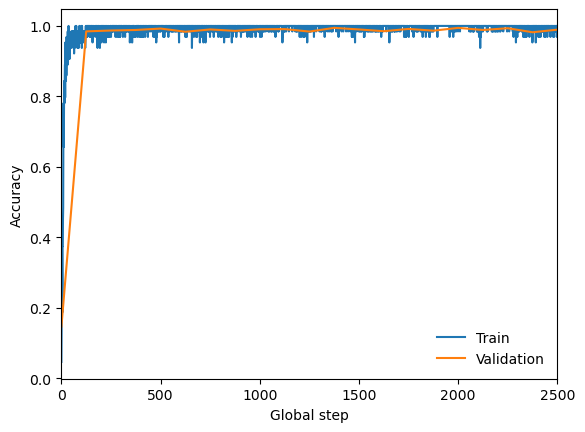

In [7]:
fig, ax = plt.subplots(1, 1)
ax.plot(oracle.lightning_module.metrics.train_steps, oracle.lightning_module.metrics.train_acc, label='Train')
ax.plot(oracle.lightning_module.metrics.val_steps, oracle.lightning_module.metrics.val_acc, label='Validation')
ax.set_xlabel('Global step')
ax.set_ylabel('Accuracy')
ax.legend(frameon=False, loc='lower right')
ax.margins(x=0)

# Model fitting

In [8]:
train_data = traj_to_contexts(Noisy_ordered_MNIST['train']['image'], backend='numpy')
val_data = traj_to_contexts(Noisy_ordered_MNIST['validation']['image'], backend='numpy')
test_data = traj_to_contexts(Noisy_ordered_MNIST['test']['image'], backend='numpy')
# test_labels = np.take(Noisy_ordered_MNIST['test']['label'], np.squeeze(test_data.__idxmap__[:, 0])).detach().cpu().numpy()
test_labels = np.take(Noisy_ordered_MNIST['test']['label'], np.squeeze(test_data.idx_map.lookback(1))).detach().cpu().numpy()
transfer_operator_models = {}

### Linear Ridge Regression

In [9]:
linear_model = Linear(reduced_rank = configs.reduced_rank, rank=configs.classes, tikhonov_reg = 48.33).fit(train_data)
transfer_operator_models['Linear'] = linear_model

### Classifier features (as in Sec. 6 of Kostic et al. 2022)

In [10]:
classifier_model = Nonlinear(oracle, reduced_rank=False, rank=configs.classes).fit(train_data)
transfer_operator_models['Classifier_Baseline'] = classifier_model

### Kernel Ridge Regression (Gaussian)

In [11]:
kernel_model = Kernel(RBF(length_scale=784), reduced_rank=True, rank = configs.classes, tikhonov_reg = 7.85e-3).fit(train_data)
transfer_operator_models['Gaussian_RRR'] = kernel_model

## Dataloader for `kooplearn`

In [12]:
from kooplearn.nn.data import collate_context_dataset

train_dl = DataLoader(train_data, batch_size = configs.batch_size, shuffle=True, collate_fn=collate_context_dataset)

### DPNets

In [13]:
from kooplearn.nn import DPLoss, VAMPLoss
trainer_kwargs = {
    'accelerator': device,
    'devices': 1,
    'max_epochs': configs.max_epochs,  
    'log_every_n_steps': 3,
    'enable_model_summary': False
}

feature_maps = {
    # 'DPNets_Relaxed': {
    #     'loss_fn': DPLoss,
    #     'loss_kwargs': {'relaxed': True, 'metric_deformation': 1, 'center_covariances': False}
    # },
    'DPNets': {
        'loss_fn': DPLoss,
        'loss_kwargs': {'relaxed': False, 'metric_deformation': 1, 'center_covariances': False}
    },
    # 'VAMPNets': {
    #     'loss_fn': VAMPLoss,
    #     'loss_kwargs': {'schatten_norm': 2, 'center_covariances': False}
    # },
    # 'EYMNets': {
    #     'loss_fn': EYMLoss,
    #     'loss_kwargs': {'center': True, 'mode': 'U_stat', 'metric_deformation': 0}
    # },
}

for fname, fdict in feature_maps.items():
    print(f"Fitting {fname.replace('_', ' ')}")
    trainer = lightning.Trainer(**trainer_kwargs)
    #Defining the model
    feature_map = NNFeatureMap(
        CNNEncoder,
        fdict['loss_fn'],
        torch.optim.Adam,
        trainer,
        encoder_kwargs={'num_classes': configs.classes},
        loss_kwargs=fdict['loss_kwargs'],
        optimizer_kwargs={'lr': 9e-4},
        seed=configs.rng_seed
    )
    feature_map.fit(train_dl)
    nn_model = Nonlinear(feature_map, reduced_rank = configs.reduced_rank, rank=configs.classes).fit(train_data)
    transfer_operator_models[fname] = nn_model

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/erfanmirzaei/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Seed set to 42


Fitting DPNets
Fitting NNFeatureMap. Lookback window length set to 1


/Users/erfanmirzaei/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


# Final comparison
## Model evaluation function

In [5]:
from kooplearn.abc import BaseModel

def evaluate_model(model: BaseModel, test_data):
    assert model.is_fitted
    report = {
        'accuracy': [],
        'accuracy_ordered':[],
        'label': [],
        'image': [],
        'times': []
    }
    for t in range(1, 20):#configs.eval_up_to_t + 1):
        pred = (model.predict(test_data, t=t)).reshape(-1, 28,28) # Shape of the lookforward window
        pred_labels = oracle(pred).argmax(axis=1)
        new_test_labels = np.array(list(test_labels[t:]) + list((test_labels[-t:] + t)% configs.classes))
        accuracy = (pred_labels == new_test_labels).mean() 
        accuracy_ordered =  (pred_labels == (test_labels + t)% configs.classes).mean()
        report['accuracy'].append(accuracy)
        report['accuracy_ordered'].append(accuracy_ordered)
        report['image'].append(pred)
        report['label'].append(pred_labels)
        report['times'].append(t)
    return report

NameError: name 'test_data' is not defined

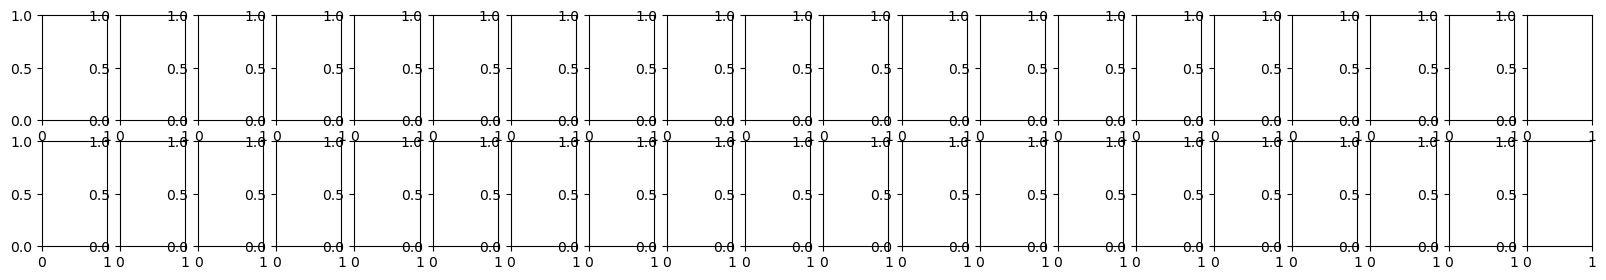

In [7]:
fig, ax = plt.subplots(2, 20, figsize=(20, 3))
test_data_np = np.array(test_data)
for i in range(20):
    data1 = test_data_np[i,0,:,:]
    label = test_labels[i]
    data2 = test_data_np[i,1,:,:]
    ax[0, i].imshow(data1, cmap='gray')
    ax[0, i].set_title(label.item())
    ax[0, i].axis('off')
    ax[1, i].imshow(data2, cmap='gray')
    ax[1, i].set_title(label.item())
    ax[1, i].axis('off')
fig.tight_layout()

In [16]:
report = {}
for model_name, model in transfer_operator_models.items():
        print(f"Evaluating {model_name.replace('_', ' ')}")
        report[model_name] = evaluate_model(model, test_data)

Evaluating Linear
Evaluating Classifier Baseline
Evaluating Gaussian RRR
Evaluating DPNets


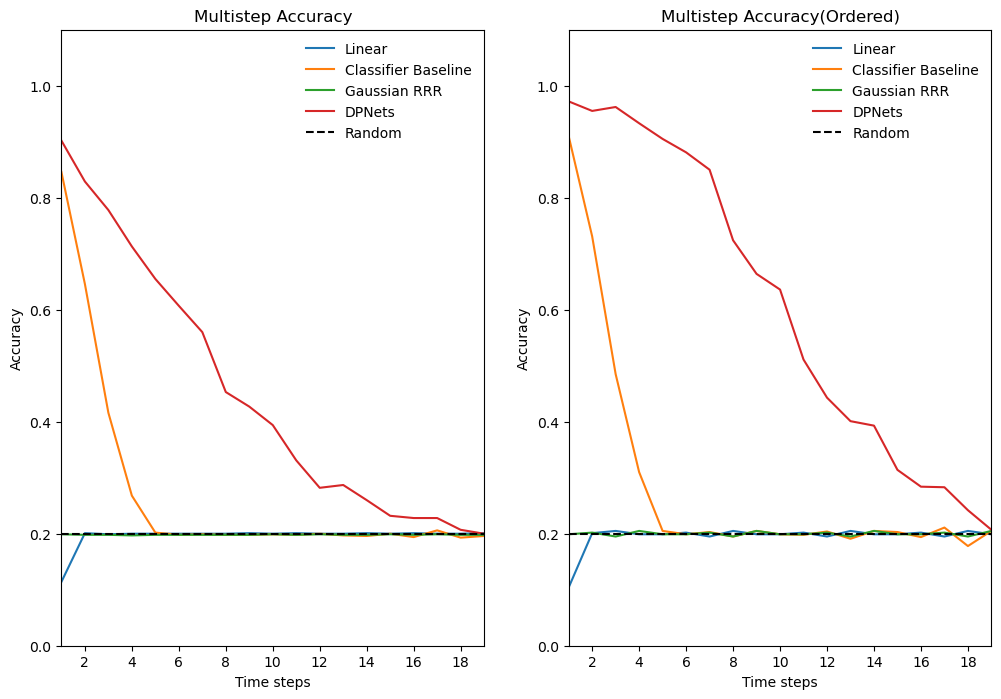

In [17]:
fig, ax = plt.subplots(1,2, figsize =(12,8))
for model_name in report.keys():
    t = report[model_name]['times']
    acc = report[model_name]['accuracy']
    acc_ordered = report[model_name]['accuracy_ordered']
    
    ax[0].plot(t, acc, label=model_name.replace('_', ' '))
    ax[1].plot(t, acc_ordered, label=model_name.replace('_', ' '))

ax[0].axhline(1/configs.classes, color='black', linestyle='--', label='Random')
ax[1].axhline(1/configs.classes, color='black', linestyle='--', label='Random')

ax[0].legend(frameon=False, bbox_to_anchor=(1, 1))
ax[0].margins(x=0)
ax[0].set_ylim(0, 1.1)
ax[0].set_xlabel('Time steps')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Multistep Accuracy')
ax[1].legend(frameon=False, bbox_to_anchor=(1, 1))
ax[1].margins(x=0)
ax[1].set_ylim(0, 1.1)
ax[1].set_xlabel('Time steps')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Multistep Accuracy(Ordered)')
plt.show()

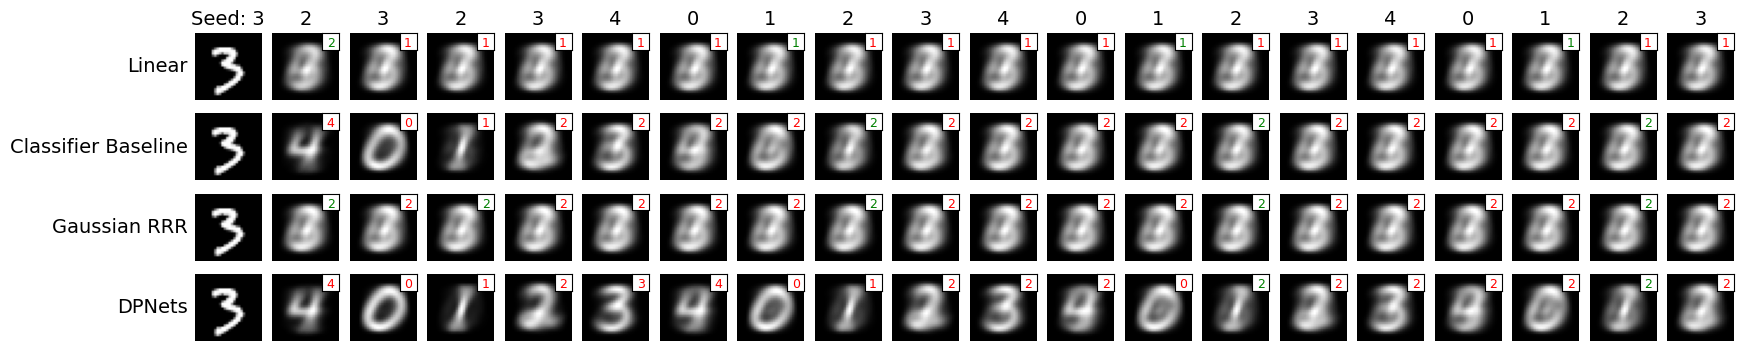

In [18]:
n_models = len(report.keys())
num_cols = 20#configs.eval_up_to_t + 1
fig, axes = plt.subplots(n_models, num_cols, figsize=(num_cols, n_models), sharex=True, sharey=True)

test_seed_idx = 0
# Remove margins between columns
plt.subplots_adjust(wspace=0)

for model_idx, model_name in enumerate(report.keys()):
    ax = axes[model_idx, 0]
    ax.imshow(Noisy_ordered_MNIST['test']['image'][test_seed_idx], cmap='gray')
    # Remove axes and ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    model_eval = report[model_name]

    for t_idx in range(num_cols - 1):
        pred_label = model_eval['label'][t_idx][test_seed_idx]
        # true_label = (Noisy_ordered_MNIST['test']['label'][test_seed_idx] + model_eval['times'][t_idx])%configs.classes
        true_label = test_labels[test_seed_idx + t_idx + 1]
        img = model_eval['image'][t_idx][test_seed_idx]

        # Set subplot for the current class
        ax = axes[model_idx, t_idx + 1]

        # Plot the MNIST image
        ax.imshow(img, cmap='gray')

        # Remove axes and ticks
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')

        # Add a white background for the subplot
        ax.set_facecolor('white')

        # Add an inset for the predicted label in the upper right corner
        if pred_label == true_label:
            color = 'green'
        else:
            color = 'red'
        inset_ax = ax.inset_axes([0.75, 0.75, 0.25, 0.25])
        inset_ax.set_xlim(0, 1)
        inset_ax.set_ylim(0, 1)
        inset_ax.text(0.5, 0.4, f"{pred_label}" , color=color, fontsize=9, ha='center', va='center')
        inset_ax.set_xticks([])
        inset_ax.set_yticks([])
        inset_ax.set_facecolor('white')

# Display the model names on the left of each row
for model_idx, model_name in enumerate(report.keys()):
    axes[model_idx, 0].text(-0.1, 0.5, model_name.replace('_', ' '), fontsize=14, ha='right', va='center', transform=axes[model_idx, 0].transAxes)

for class_idx in range(num_cols):
    title = test_labels[test_seed_idx + class_idx] #(Noisy_ordered_MNIST['test']['label'][test_seed_idx] + class_idx)%configs.classes
    if class_idx == 0:
        axes[0, class_idx].set_title(f"Seed: {title}", fontsize=14)
    else:
        axes[0, class_idx].set_title(f"{title}", fontsize=14)
plt.show()

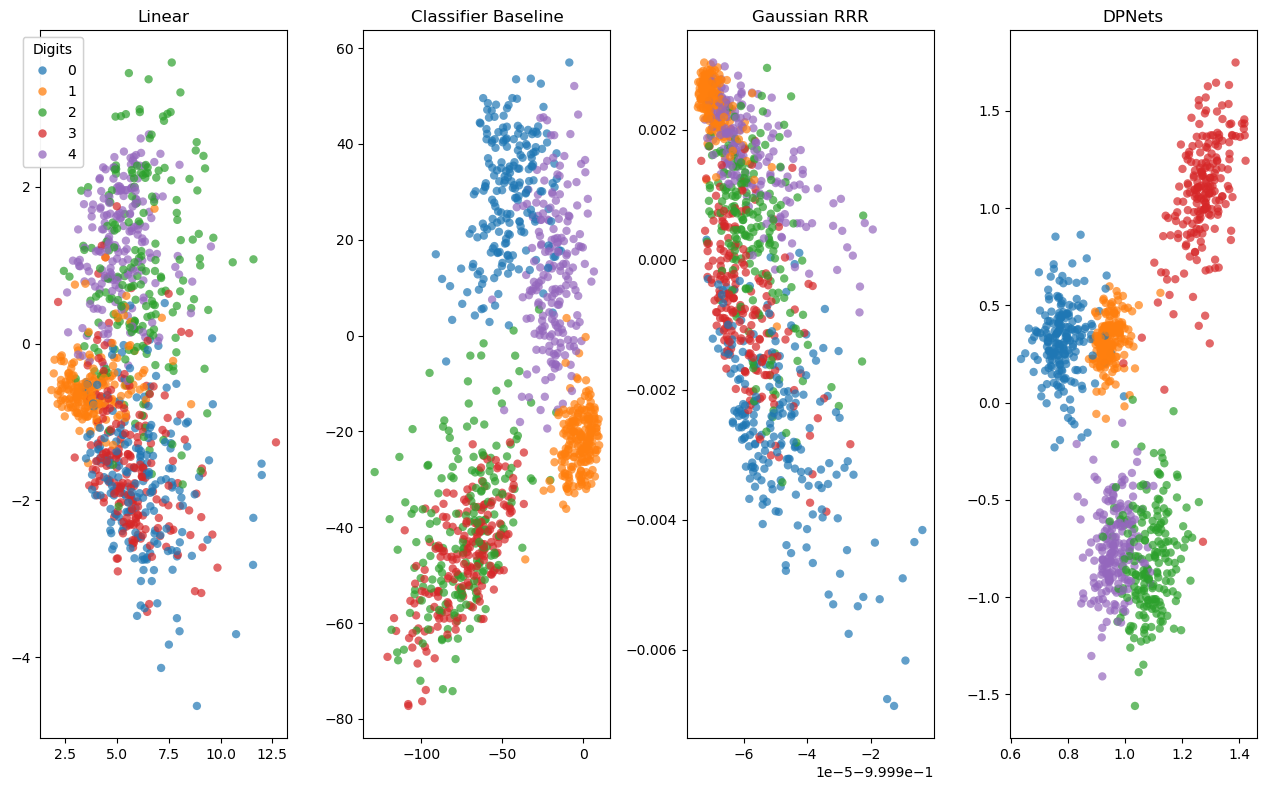

In [41]:
from kooplearn.utils import topk

n_models = len(report.keys())
num_rows = 1
num_cols = n_models +1
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 8))
axes = axes.flatten()
for model_idx, model_name in enumerate(report.keys()):
    ax = axes[model_idx]
    ax.title.set_text(model_name.replace('_', ' '))
    fitted_model = transfer_operator_models[model_name]
    vals, lfuncs, rfuncs = fitted_model.eig(eval_right_on=test_data, eval_left_on=test_data)
    
    unique_vals, idx_start = np.unique(np.abs(vals), return_index=True) # returns the unique values and the index of the first occurrence of a value
    
    vals, lfuncs, rfuncs = vals[idx_start], lfuncs[:, idx_start], rfuncs[:, idx_start]
    top_vals = topk(np.abs(vals), 2)
    idx_i = top_vals.indices[0]
    idx_j = top_vals.indices[1]
    
    fns = lfuncs
    fn_i = fns[:, idx_i].real
    fn_j = fns[:, idx_j].real
    
    scatter = ax.scatter(fn_i, fn_j, c=test_labels, cmap='tab10', vmax=10, alpha=0.7, linewidths=0)
    
# remove last axis and add legend
ax = axes[0]
legend = ax.legend(*scatter.legend_elements(num=4),
                    title="Digits", frameon=True, bbox_to_anchor=(0.2, 1))
ax.add_artist(legend)
fig.delaxes(axes[n_models])
    
plt.tight_layout()
plt.show()

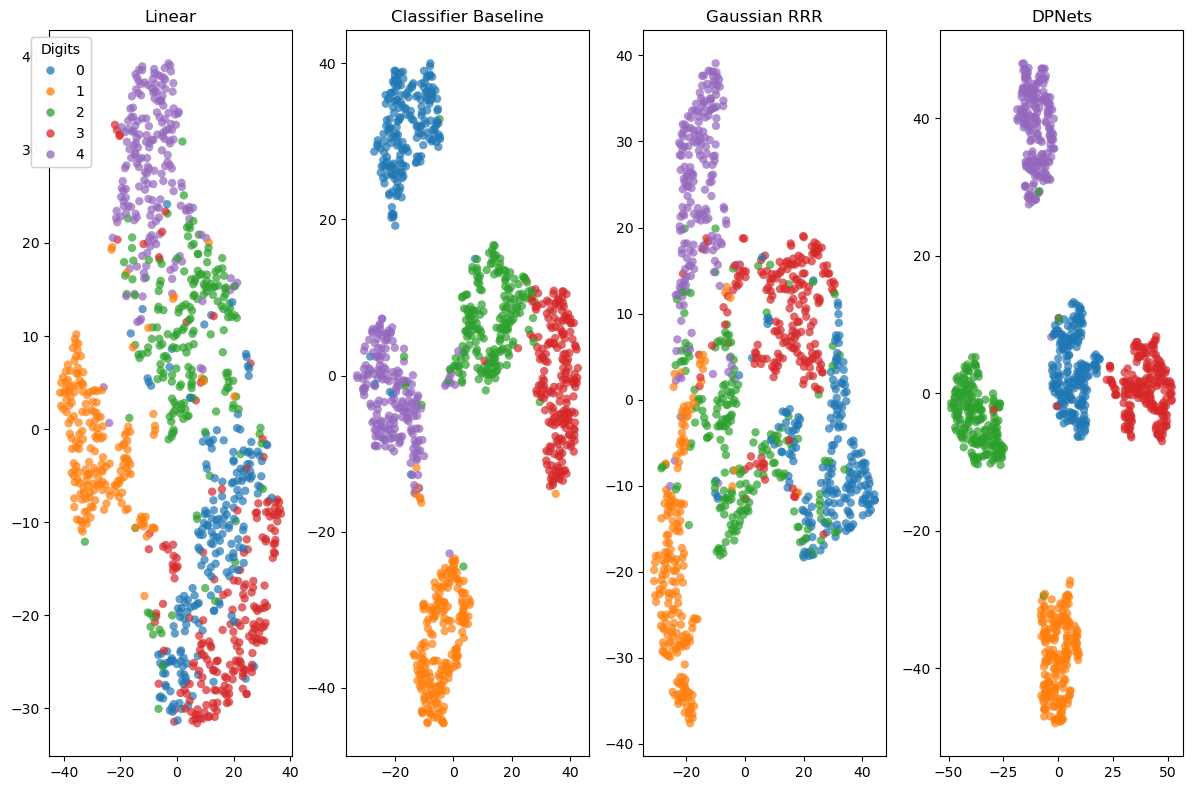

In [42]:
from sklearn.manifold import TSNE
DimReduction = TSNE

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))
axes = axes.flatten()
for model_idx, model_name in enumerate(report.keys()):
    ax = axes[model_idx]
    ax.title.set_text(model_name.replace('_', ' '))
    fitted_model = transfer_operator_models[model_name]
    vals, lfuncs, rfuncs = fitted_model.eig(eval_right_on=test_data, eval_left_on=test_data)
    
    # returns the unique values and the index of the first occurrence of a value
    unique_vals, idx_start = np.unique(np.abs(vals), return_index=True) 
    
    vals, lfuncs, rfuncs = vals[idx_start], lfuncs[:, idx_start], rfuncs[:, idx_start]
    
    fns = lfuncs
    fns = np.column_stack([lfuncs, rfuncs])
    reduced_fns = DimReduction(n_components=2, random_state=42).fit_transform(fns.real)    
    fn_i = reduced_fns[:, 0]
    fn_j = reduced_fns[:, 1]
    
    scatter = ax.scatter(fn_i, fn_j, c=test_labels, cmap='tab10', vmax=10, alpha=0.7, linewidths=0)

# remove last axis and add legend
ax = axes[0]
legend = ax.legend(*scatter.legend_elements(num=4),
                    title="Digits", frameon=True, bbox_to_anchor=(0.2, 1))
ax.add_artist(legend)
fig.delaxes(axes[n_models])
    
plt.tight_layout()
plt.show()

In [1]:
#choose a big n, then try to do everything. 

In [2]:
#pay attention to increasing number of classes. Track the performance of your oracle. 

In [2]:
import importlib

for module in ['kooplearn', 'datasets', 'matplotlib', 'ml-confs']: # !! Add here any additional module that you need to install on top of kooplearn
    try:
        importlib.import_module(module)
    except ImportError:
        if module == 'kooplearn':
            module = 'kooplearn[full]'
        %pip install -q {module}

import data_pipeline
import ml_confs
from datasets import load_from_disk
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import lightning
from typing import Optional, NamedTuple
import logging
from kooplearn.abc import TrainableFeatureMap
from kooplearn.models import Linear, Nonlinear, Kernel
from kooplearn.models.feature_maps.nn import NNFeatureMap
from kooplearn.nn.data import collate_context_dataset
from kooplearn.nn import DPLoss, VAMPLoss
from kooplearn.data import traj_to_contexts
from sklearn.gaussian_process.kernels import RBF

Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch.nn as nn
import torch

#Setting up the architecture
class CNNEncoder(nn.Module):
    def __init__(self, num_classes):
        super(CNNEncoder, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # Fully connected layer, output num_classes classes
        self.out = nn.Sequential(
            nn.Linear(32 * 7 * 7, num_classes)
        )  
        torch.nn.init.orthogonal_(self.out[0].weight)      
    
    def forward(self, X):
        if X.dim() == 3:
            X = X.unsqueeze(1) # Add a channel dimension if needed
        X = self.conv1(X)
        X = self.conv2(X)
        # Flatten the output of conv2
        X = X.view(X.size(0), -1)       
        output = self.out(X)
        return output

In [4]:
from kooplearn.abc import TrainableFeatureMap

import os
from typing import Optional, NamedTuple
import logging

import lightning
import numpy as np

class Metrics(NamedTuple):
    train_acc: list[float]
    train_steps: list[float]
    val_acc: list[float]
    val_steps: list[float]


#Following kooplearn implementations, we define a Pytorch Lightning module and then wrap it in a TrainableFeatureMap
class ClassifierModule(lightning.LightningModule):
    def __init__(self, num_classes: int, learning_rate: float):
        super().__init__()
        self.num_classes = num_classes
        self.encoder = CNNEncoder(num_classes=num_classes)
        self.learning_rate = learning_rate
        self.loss_fn = torch.nn.CrossEntropyLoss()
    
    def on_fit_start(self):
        self.metrics = Metrics([], [], [], [])

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr = self.learning_rate)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        images, labels = batch['image'], batch['label']
        output = self.encoder(images)               
        loss = self.loss_fn(output, labels)
        with torch.no_grad():
            pred_labels = output.argmax(dim=1)
            accuracy = (pred_labels == labels).float().mean()
        
        #Log metrics
        self.metrics.train_acc.append(accuracy.item())
        self.metrics.train_steps.append(self.global_step)
        
        return {'loss': loss, 'train/accuracy': accuracy}
    
    def validation_step(self, batch, batch_idx):
        images, labels = batch['image'], batch['label']
        output = self.encoder(images)  
        pred_labels = output.argmax(dim=1)
        accuracy = (pred_labels == labels).float().mean() # Scalar

        self.metrics.val_acc.append(accuracy.item())
        self.metrics.val_steps.append(self.global_step)

        return {'val/accuracy': accuracy}
    
class ClassifierFeatureMap(TrainableFeatureMap):
    def __init__(
                self, 
                num_classes: int,
                learning_rate: float,
                trainer: lightning.Trainer,
                seed: Optional[int] = None  
                ):
        #Set rng seed
        lightning.seed_everything(seed)
        self.seed = seed
        self.lightning_module = ClassifierModule(num_classes, learning_rate)
        
        #Init trainer
        self.lightning_trainer = trainer
        self._is_fitted = False
        
    @property
    def is_fitted(self) -> bool:
        return self._is_fitted
    
    @property
    def lookback_len(self) -> int:
        return 1 #Hardcoding it here, as we are not using lookback windows
    
    #Not tested
    def save(self, path: os.PathLike):
        raise NotImplementedError
    
    #Not tested
    @classmethod
    def load(cls, path: os.PathLike):
       raise NotImplementedError

    def fit(self, **trainer_fit_kwargs: dict):
        if 'model' in trainer_fit_kwargs:
            logging.warn(f"The 'model' keyword should not be specified in trainer_fit_kwargs. The provided model '{trainer_fit_kwargs['model']}' is ignored.")
            trainer_fit_kwargs = trainer_fit_kwargs.copy()
            del trainer_fit_kwargs['model']
        self.lightning_trainer.fit(model=self.lightning_module, **trainer_fit_kwargs)
        self._is_fitted = True

    def __call__(self, X: np.ndarray) -> np.ndarray:
        X = torch.from_numpy(X.copy(order="C")).float()
        self.lightning_module.eval()
        with torch.no_grad():
            embedded_X = self.lightning_module.encoder(
                X.to(self.lightning_module.device)
            )
            embedded_X = embedded_X.detach().cpu().numpy()
        return embedded_X

In [5]:
def make_block_matrices(matrix, tau):
    n = matrix.shape[0]
    assert n % tau == 0, "Matrix dimensions must be divisible by tau"

    n_blocks = n // tau
    blocks = matrix.reshape(n_blocks, tau, n_blocks, tau)
    block_matrix_result = blocks.transpose(0, 2, 1, 3)
    
    return block_matrix_result

In [6]:
def biased_covariance_estimator(cov_mtx, tau):
    n = cov_mtx.shape[0]
    block_cov_matrix = make_block_matrices(cov_mtx,tau)
    diag_blocks = torch.diagonal(torch.from_numpy(block_cov_matrix), offset=0, dim1=0, dim2=1)
    return torch.sum(torch.pow(diag_blocks,2))/(n*tau)

def unbiased_covariance_estimator(cov_mtx, tau):
    n = cov_mtx.shape[0]
    block_cov_matrix = make_block_matrices(cov_mtx,tau)
    block_cov_matrix = torch.from_numpy(block_cov_matrix)

    diag_blocks = torch.diagonal(block_cov_matrix, offset=0, dim1=0, dim2=1)
    plus_term = torch.sum(torch.pow(diag_blocks,2))
    minus_term = 0
    for signed in [1,-1]:
        for i in range(2,n, 2):
            diag_blocks = torch.diagonal(block_cov_matrix, offset=i*signed, dim1=0, dim2=1)
            minus_term += torch.sum(torch.pow(diag_blocks,2)) 
    
    # print(plus_term, minus_term)
    sum = plus_term - (minus_term / ((n/(2*tau))-1))
    if sum < 0:
        sum = 0.0

    return sum /(n*tau)

In [7]:
from kooplearn.abc import BaseModel

def evaluate_model(model: BaseModel, test_data):
    assert model.is_fitted
    report = {
        'accuracy': [],
        'accuracy_ordered':[],
        'label': [],
        'image': [],
        'times': []
    }
    for t in range(1, 20):#configs.eval_up_to_t + 1):
        pred = (model.predict(test_data, t=t)).reshape(-1, 28,28) # Shape of the lookforward window
        pred_labels = oracle(pred).argmax(axis=1)
        new_test_labels = np.array(list(test_labels[t:]) + list((test_labels[-t:] + t)% configs.classes))
        accuracy = (pred_labels == new_test_labels).mean() 
        accuracy_ordered =  (pred_labels == (test_labels + t)% configs.classes).mean()
        report['accuracy'].append(accuracy)
        report['accuracy_ordered'].append(accuracy_ordered)
        report['image'].append(pred)
        report['label'].append(pred_labels)
        report['times'].append(t)
    return report

In [ ]:
Ns = [500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000,6500,7000,7500,8000]
n_0 = len(Ns)
delta = 0.05
configs = ml_confs.from_file('configs.yaml') # Load configs
device = 'gpu' if torch.cuda.is_available() else 'cpu'

biased_cov_ests = {'Linear' : np.empty((n_0, configs.n_repits)),
                   'Gaussian_RRR':np.empty((n_0, configs.n_repits)),
                   'Classifier_Baseline':np.empty((n_0, configs.n_repits)),
                   'DPNets':np.empty((n_0, configs.n_repits))}

unbiased_cov_ests = {'Linear' : np.empty((n_0, configs.n_repits)),
                   'Gaussian_RRR':np.empty((n_0, configs.n_repits)),
                   'Classifier_Baseline':np.empty((n_0, configs.n_repits)),
                   'DPNets':np.empty((n_0, configs.n_repits))}

lower_bound = np.empty((n_0, configs.n_repits))

random.seed(configs.rng_seed)
np.random.seed(configs.rng_seed)
torch.manual_seed(configs.rng_seed)

for i in range(configs.n_repits):  
    
    data_pipeline.main() # Run data download and preprocessing
    configs = ml_confs.from_file('configs.yaml') # Load configs
    ordered_MNIST = load_from_disk('__data__') # Load dataset (torch)
    Noisy_ordered_MNIST = load_from_disk('__data__Noisy') # Load dataset (torch)
    for j in range(len(Ns)):
        n = Ns[j]
        for tau in range(1,n):
            if delta >= 2*(n/(2*tau) - 1)*np.exp(-(np.exp(1) -  1)/np.exp(1)*tau) and (n / tau) % 2 == 0 :
                min_tau = tau
                break
        tau = min_tau 
        oracle_train_dl = DataLoader(ordered_MNIST['train'].select(range(n)), batch_size=configs.batch_size, shuffle=True)
        oracle_val_dl = DataLoader(ordered_MNIST['validation'].select(range(n//5)), batch_size=len(ordered_MNIST['validation']), shuffle=False)
                
        trainer_kwargs = {
            'accelerator': device,
            'max_epochs': 20,
            'log_every_n_steps': 2,
            'enable_progress_bar': False,
            'devices': 1
        }

        trainer = lightning.Trainer(**trainer_kwargs)

        oracle = ClassifierFeatureMap(
            configs.classes,
            1e-2,
            trainer, 
            seed=configs.rng_seed
        )

        oracle.fit(train_dataloaders=oracle_train_dl, val_dataloaders=oracle_val_dl)
        print(oracle.lightning_module.metrics.val_acc[-1])
        new_train_dataset = Noisy_ordered_MNIST['train'].select(list(range(n)))
        new_val_dataset = Noisy_ordered_MNIST['validation'].select(range(n//5))
        train_data = traj_to_contexts(new_train_dataset['image'], backend='numpy')
        val_data = traj_to_contexts(new_val_dataset['image'], backend='numpy')
        test_data = traj_to_contexts(Noisy_ordered_MNIST['test']['image'], backend='numpy')
        test_labels = np.take(Noisy_ordered_MNIST['test']['label'], np.squeeze(test_data.idx_map.lookback(1))).detach().cpu().numpy()

        transfer_operator_models = {}
        
        linear_model = Linear(reduced_rank = configs.reduced_rank, rank=configs.classes, tikhonov_reg = 48.33).fit(train_data)
        transfer_operator_models['Linear'] = linear_model 
        
        classifier_model = Nonlinear(oracle, reduced_rank=False, rank=configs.classes).fit(train_data)
        transfer_operator_models['Classifier_Baseline'] = classifier_model

        kernel_model = Kernel(RBF(length_scale=784), reduced_rank=True, rank = configs.classes, tikhonov_reg = 7.85e-3).fit(train_data)
        transfer_operator_models['Gaussian_RRR'] = kernel_model    
        
        train_dl = DataLoader(train_data, batch_size = configs.batch_size, shuffle=True, collate_fn=collate_context_dataset)
        trainer_kwargs = {
            'accelerator': device,
            'devices': 1,
            'max_epochs': configs.max_epochs,  
            'log_every_n_steps': 3,
            'enable_model_summary': False
        }

        feature_maps = {
            # 'DPNets_Relaxed': {
            #     'loss_fn': DPLoss,
            #     'loss_kwargs': {'relaxed': True, 'metric_deformation': 1, 'center_covariances': False}
            # },
            'DPNets': {
                'loss_fn': DPLoss,
                'loss_kwargs': {'relaxed': False, 'metric_deformation': 1, 'center_covariances': False}
            },
            # 'VAMPNets': {
            #     'loss_fn': VAMPLoss,
            #     'loss_kwargs': {'schatten_norm': 2, 'center_covariances': False}
            # },
            # 'EYMNets': {
            #     'loss_fn': EYMLoss,
            #     'loss_kwargs': {'center': True, 'mode': 'U_stat', 'metric_deformation': 0}
            # },
        }

        for fname, fdict in feature_maps.items():
            print(f"Fitting {fname.replace('_', ' ')}")
            trainer = lightning.Trainer(**trainer_kwargs)
            #Defining the model
            feature_map = NNFeatureMap(
                CNNEncoder,
                fdict['loss_fn'],
                torch.optim.Adam,
                trainer,
                encoder_kwargs={'num_classes': configs.classes},
                loss_kwargs=fdict['loss_kwargs'],
                optimizer_kwargs={'lr': 9e-4},
                seed=configs.rng_seed
            )
            feature_map.fit(train_dl)
            nn_model = Nonlinear(feature_map, reduced_rank = configs.reduced_rank, rank=configs.classes).fit(train_data)
            transfer_operator_models[fname] = nn_model    
        

        
        report = {}
        for model_name, model in transfer_operator_models.items():
                print(f"Evaluating {model_name.replace('_', ' ')}")
                report[model_name] = evaluate_model(model, test_data)

        
        kernel_matrices = {}
        fm_linear = new_train_dataset['image'].numpy().reshape(n, -1)
        # print(fm_linear.shape)
        kernel_matrices['Gaussian_RRR'] = kernel_model._kernel(fm_linear, fm_linear)
        # print(kernel_matrices['Gaussian_RRR'].shape)
        fm_dpnet = feature_map(new_train_dataset['image'].numpy())
        # print(fm_dpnet.shape)
        fm_classifier = oracle(new_train_dataset['image'].numpy())
        # print(fm_classifier.shape)
        kernel_matrices['DPNets'] = fm_dpnet @ fm_dpnet.T
        kernel_matrices['Classifier_Baseline'] = fm_classifier @ fm_classifier.T
        kernel_matrices['Linear'] = fm_linear @ fm_linear.T
        
        
        for model_name in transfer_operator_models: 
            # print(kernel_matrices[model_name].shape[0], tau)
            biased_cov_ests[model_name][j][i] = biased_covariance_estimator(kernel_matrices[model_name], tau= tau)
            unbiased_cov_ests[model_name][j][i] = unbiased_covariance_estimator(kernel_matrices[model_name], tau= tau)

        lower_bound[j][i] = 1 / tau

In [25]:
unbiased_cov_ests['Linear'][:,0]

array([329.95504761, 399.5480957 , 504.00338745, 411.34020996,
       339.66976929, 521.53509521, 559.8848877 , 496.59136963,
       528.24993896, 413.48831177, 380.51651001, 521.32299805,
       344.6862793 , 409.43222046, 526.17956543, 494.43737793])

In [26]:
unbiased_cov_ests['Classifier_Baseline'][:,0]

array([  13434.68554688,   70289.8671875 ,   57114.39453125,
         64448.71875   ,   51464.9609375 ,  295486.15625   ,
        142555.515625  ,   75099.7734375 ,  366779.25      ,
        489502.8125    ,  741757.5625    , 2381646.75      ,
        180675.09375   ,  373051.03125   , 1301499.5       ,
        631253.5       ])

In [22]:
unbiased_cov_ests['DPNets'][:,0]

array([0.14014344, 0.2084754 , 0.22515903, 0.18799804, 0.221348  ,
       0.26140279, 0.31421524, 0.24112841, 0.23267175, 0.30672938,
       0.17199896, 0.27814895, 0.14996615, 0.20637769, 0.26300946,
       0.25530127])

In [24]:
unbiased_cov_ests['Gaussian_RRR'][:,0]

array([6.71513657e-06, 8.55358417e-06, 1.08069892e-05, 8.56205333e-06,
       7.23818845e-06, 1.10500523e-05, 1.17015166e-05, 1.03514099e-05,
       1.10530250e-05, 8.62811186e-06, 8.11679819e-06, 1.11614844e-05,
       7.35860448e-06, 8.70704573e-06, 1.11731045e-05, 1.04683139e-05])

In [21]:
lower_bound[:,0]

array([0.04      , 0.05      , 0.06666667, 0.05      , 0.04      ,
       0.06666667, 0.07142857, 0.0625    , 0.06666667, 0.05      ,
       0.04545455, 0.06666667, 0.04      , 0.05      , 0.06666667,
       0.0625    ])

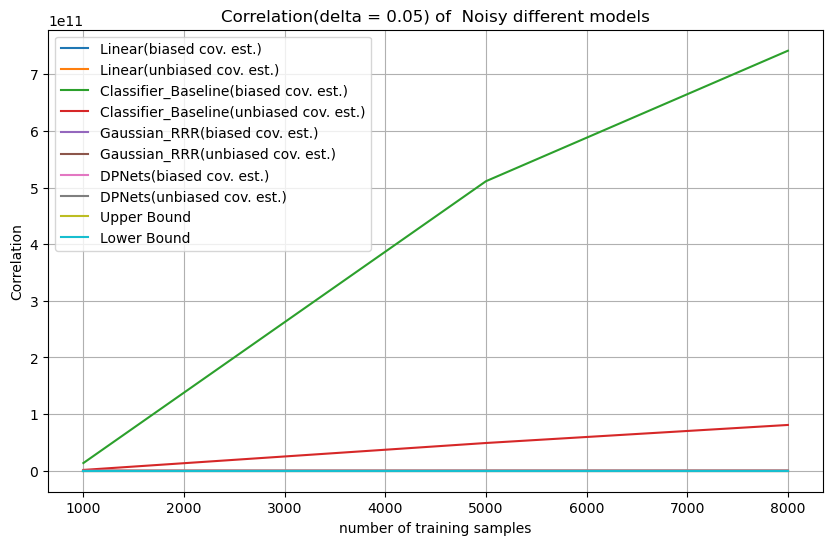

In [8]:
# Plot
plt.figure(figsize=(10, 6))

for model_name in transfer_operator_models:
    biased_est_mean = np.mean(biased_cov_ests[model_name], axis=-1)
    biased_est_std = np.std(biased_cov_ests[model_name], axis=-1)
    plt.plot(Ns, biased_est_mean, label=f"{model_name}(biased cov. est.)")
    plt.fill_between(Ns, biased_est_mean - biased_est_std, biased_est_mean + biased_est_std, alpha=0.2)

    unbiased_est_mean = np.mean(unbiased_cov_ests[model_name], axis=-1)
    unbiased_est_std = np.std(unbiased_cov_ests[model_name], axis=-1)
    plt.plot(Ns, unbiased_est_mean, label=f"{model_name}(unbiased cov. est.)")
    plt.fill_between(Ns, unbiased_est_mean - unbiased_est_std, unbiased_est_mean + unbiased_est_std, alpha=0.2)

plt.plot(Ns, np.ones((n_0,1)), label = 'Upper Bound',)
plt.plot(Ns, lower_bound[:,0], label = 'Lower Bound',)

plt.xlabel("number of training samples")
plt.ylabel("Correlation")
plt.title(f"Correlation(delta = {delta}) of  Noisy different models")
plt.legend()
plt.grid(True)
plt.show()

In [28]:
biased_cov_ests['Linear'][:,0]

array([2014.88769531, 2066.28857422, 2124.45947266, 2145.80566406,
       1972.0501709 , 2201.19116211, 2275.07275391, 2237.16992188,
       2265.24658203, 2121.78344727, 2062.91357422, 2183.64575195,
       2002.67773438, 2074.80810547, 2206.86694336, 2166.34570312])

In [30]:
biased_cov_ests['Classifier_Baseline'][:,0]

array([  139115.15625,   677319.875  ,   427139.75   ,   674573.125  ,
         741428.5625 ,  1944999.75   ,  1314640.25   ,   731152.125  ,
        2688248.25   ,  5111286.5    ,  9446058.     , 19339558.     ,
        2440167.5    ,  4440988.     , 12197262.     ,  5792851.5    ])

In [32]:
biased_cov_ests['DPNets'][:,0]

array([4.46095657, 4.63630772, 4.24683905, 4.5585084 , 4.39814615,
       4.77521324, 5.2475872 , 4.5541935 , 3.98159814, 5.00486755,
       4.75564098, 5.31904078, 5.13604403, 5.36253357, 4.80831575,
       4.67119598])

In [33]:
unbiased_cov_ests['Gaussian_RRR'][:,0]

array([6.71513657e-06, 8.55358417e-06, 1.08069892e-05, 8.56205333e-06,
       7.23818845e-06, 1.10500523e-05, 1.17015166e-05, 1.03514099e-05,
       1.10530250e-05, 8.62811186e-06, 8.11679819e-06, 1.11614844e-05,
       7.35860448e-06, 8.70704573e-06, 1.11731045e-05, 1.04683139e-05])

In [35]:
lower_bound[:,0]

array([0.04      , 0.05      , 0.06666667, 0.05      , 0.04      ,
       0.06666667, 0.07142857, 0.0625    , 0.06666667, 0.05      ,
       0.04545455, 0.06666667, 0.04      , 0.05      , 0.06666667,
       0.0625    ])

In [34]:
1/lower_bound[:,0]

array([25., 20., 15., 20., 25., 15., 14., 16., 15., 20., 22., 15., 25.,
       20., 15., 16.])